In [ ]:
import os
import time
import argparse
import numpy as np
import h5py
from concurrent import futures
from scipy.ndimage import convolve
import matplotlib.pyplot as plt
import vigra

import nifty
import nifty.graph.opt.multicut as nmc
import nifty.graph.opt.lifted_multicut as nlmc

ModuleNotFoundError: ignored

Items in base directory: [('affinities', <HDF5 dataset "affinities": shape (17, 30, 512, 512), type "<f4">), ('labels', <HDF5 group "/labels" (2 members)>), ('raw', <HDF5 dataset "raw": shape (30, 512, 512), type "<f4">)]
items in labels: [('gt_segmentation', <HDF5 dataset "gt_segmentation": shape (30, 512, 512), type "<u8">), ('membrabes', <HDF5 dataset "membrabes": shape (30, 512, 512), type "<f4">)]


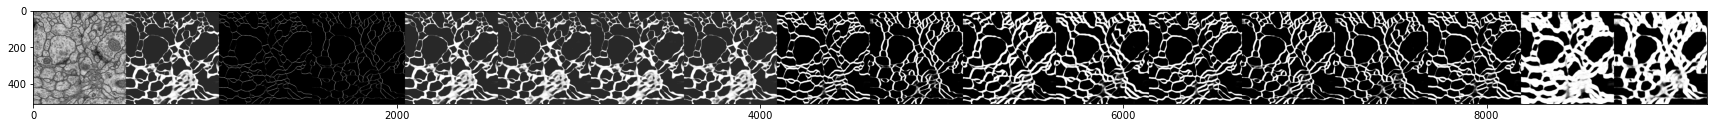

In [ ]:
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

filename = "mws_data_isbi/isbi_train_volume.h5"
with h5py.File(filename, "r") as infile:
  base_items=list(infile.items())
  print("Items in base directory:", base_items)
  labels=infile.get('labels')
  label_item=list(labels.items())
  print("items in labels:", label_item)
  raw = infile["raw"][:]
  affinities = infile["affinities"][:]
  membranes  = labels['membrabes'][:] 
  groundtruth = labels["gt_segmentation"][:]

fig = plt.figure(figsize=(30,20))
plt.imshow(np.concatenate((raw[0], ) + tuple(affinities[c, 0] for c in range(len(affinities))), axis=1), cmap='gray')

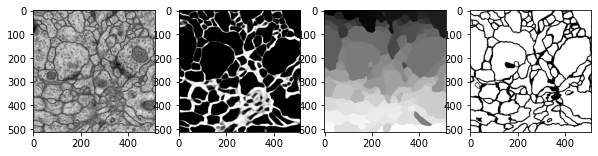

In [ ]:
display = [raw[0],affinities[0][0],groundtruth[0],membranes[0]]
label = ['Original Image[0]','affinities[0]', 'Ground Truth[0]','membrane[0]']
fig = plt.figure(figsize=(10,10))

for i in range(len(display)):
  #p=np.int(len(display)//2)
  fig.add_subplot(1,4, i+1)
  plt.imshow(display[i], cmap = 'gray')
#   plt.title(label[i])

plt.show()

# Thresholding Technique

In [ ]:
def make_pmap(affinities):
    return np.maximum(affinities[1], affinities[2])
def timer(func):
    def func_wrapper(*args, **kwargs):
        t0 = time.time()
        segmentation = func(*args, **kwargs)
        return segmentation, time.time() - t0
    return func_wrapper
def writeHDF5(data, path, key, **kwargs):
    with h5py.File(path) as f:
        f.create_dataset(key, data=data, **kwargs)
@timer
def threshold_baseline(pmap, threshold):
    import vigra
    pmap_segmentation = np.zeros_like(pmap, dtype='uint32')
    pmap_segmentation[pmap > threshold] = 1
    for z in range(pmap_segmentation.shape[0]):
        pmap_segmentation[z] = vigra.analysis.labelImageWithBackground(pmap_segmentation[z])
    return pmap_segmentation

Computing threshold segmentation ...
... finished in 1.170863 s


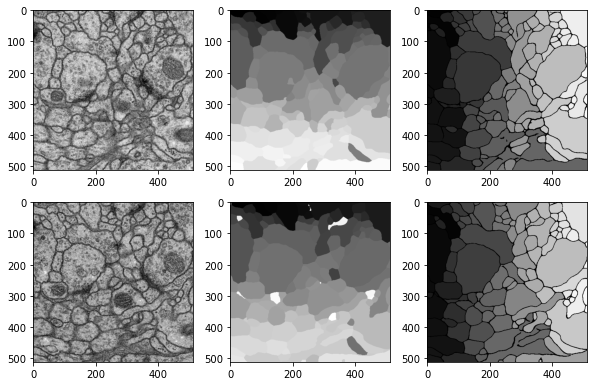

In [ ]:
pmap = make_pmap(affinities)
segmentations = []
labels = []
threshold =True
if threshold:
    thresh = 0.9
    print("Computing threshold segmentation ...")
    # thresh_seg, = threshold_baseline(1. - pmap, thresh)
    thresh_seg, t_thresh = threshold_baseline(1. -pmap, thresh)
    print("... finished in %f s" % t_thresh)
#     writeHDF5(thresh_seg, os.path.join('mws_data_isbi/result_folder_mws', 'threshold_train.h5'),
#               'data', compression='gzip')
#     segmentations.append(thresh_seg)
#     labels.append('thresholded')
display = [raw[0],groundtruth[0],thresh_seg[0],raw[1],groundtruth[1],thresh_seg[1]]
label = ['Original Image[0]', 'Ground Truth[0]','Threshold segmentation[0]','Original Image[1]', 'Ground Truth[1]','Threshold segmentation[1]']
fig = plt.figure(figsize=(10,10))

for i in range(len(display)):
  p=np.int(len(display)/2)
  fig.add_subplot(p,p, i+1)
  plt.imshow(display[i], cmap = 'gray')
#   plt.title(label[i])

plt.show()

In [ ]:
pmap = make_pmap(affinities)
# segmentations = []
# labels = []
# threshold =True
# if threshold:
#     thresh = 0.9
#     print("Computing threshold segmentation ...")
#     # thresh_seg, = threshold_baseline(1. - pmap, thresh)

# Watershed Method

In [ ]:
############# watershed segmentation ###########

import multiprocessing
from concurrent import futures
import numpy as np
import vigra
import vigra.filters as ff

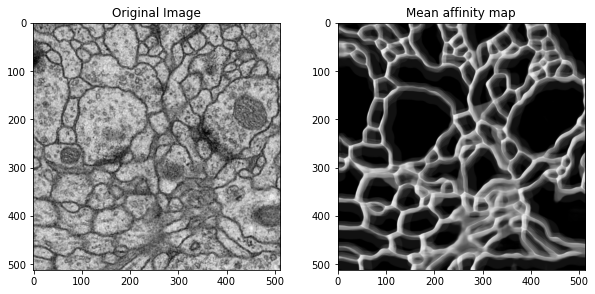

In [ ]:
# compute watershed over-segmentation based on the affinity maps

# first, we have to make a single channel input map for the watershed,which is obtained by averaging the afifnities
boundary_input = np.mean(affinities, axis=0)
display = [raw[0], boundary_input[0]]
label = ['Original Image', 'Mean affinity map']
fig = plt.figure(figsize=(10,10))

for i in range(len(display)):
  p=np.int(len(display)/2)
  fig.add_subplot(2,2, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()

In [ ]:
def apply_size_filter(segmentation, input_, size_filter, exclude=None):
    """ Apply size filter to segmentation.

    Arguments:
        segmentation [np.ndarray] - input segmentation.
        input_ [np.ndarray] - input height map.
        size_filter [int] - minimal segment size.
        exclude [list] - list of segment ids that will not be size filtered (default: None).

    Returns:
        np.ndarray - size filtered segmentation
        int - max id of size filtered segmentation
    """
    ids, sizes = np.unique(segmentation, return_counts=True)
    filter_ids = ids[sizes < size_filter]
    if exclude is not None:
        filter_ids = filter_ids[np.logical_not(np.in1d(filter_ids, exclude))]
    filter_mask = np.in1d(segmentation, filter_ids).reshape(segmentation.shape)
    segmentation[filter_mask] = 0
    _, max_id = vigra.analysis.watershedsNew(input_, seeds=segmentation, out=segmentation)
    return segmentation, max_id

def watershed(input_, seeds, size_filter=0, exclude=None):
    """ Compute seeded watershed.

    Arguments:
        input_ [np.ndarray] - input heat map.(the image or volume containing the boundary indicator values)
        seeds [np.ndarray] - seed map.
        size_filter [int] - minimal segment size (default: 0).
        exclude [list] - list of segment ids that will not be size filtered (default: None).

    Returns:
        np.ndarray - watershed segmentation
        int - max id of watershed segmentation
    """
    ws, max_id = vigra.analysis.watershedsNew(input_, seeds=seeds)   
    #Compute the watersheds of a 2D image

    if size_filter > 0:
        ws, max_id = apply_size_filter(ws, input_, size_filter,
                                       exclude=exclude)
    return ws, max_id

def distance_transform_watershed(input_, threshold, sigma_seeds,
                                 sigma_weights=2., min_size=100,
                                 alpha=.9, pixel_pitch=None,
                                 apply_nonmax_suppression=False,
                                 mask=None):
    """ Compute watershed segmentation based on distance transform seeds.

    Arguments:
        input_ [np.ndarray] - input height map.
        threshold [float] - value for the threshold applied before distance tranform.
        sigma_seeds [float] - smoothing factor for the watershed seed map.
        sigma_weigths [float] - smoothing factor for the watershed weight map (default: 2).
        min_size [int] - minimal size of watershed segments (default: 100)
        alpha [float] - alpha used to blend input_ and distance_transform in order to obtain the
            watershed weight map (default: .9)
        pixel_pitch [listlike[int]] - anisotropy factor used to compute the distance transform (default: None)
        apply_nonmax_suppression [bool] - whetther to apply non-maxmimum suppression to filter out seeds.
            Needs nifty. (default: False)
        mask [np.ndarray] - mask to exclude from segmentation (default: None)

    Returns:
        np.ndarray - watershed segmentation
        int - max id of watershed segmentation
    """
    if apply_nonmax_suppression and nonMaximumDistanceSuppression is None:
        raise ValueError("Non-maximum suppression is only available with nifty.")

    # check the mask if it was passed
    if mask is not None:
        if mask.shape != input_.shape or mask.dtype != np.dtype('bool'):
            raise ValueError("Invalid mask")

        # return all zeros for empty mask
        if mask.sum() == 0:
            return np.zeros_like(mask, dtype='uint32'), 0

    # threshold the input and compute distance transform
    thresholded = (input_ > threshold).astype('uint32')

    dt = vigra.filters.distanceTransform(thresholded, pixel_pitch=pixel_pitch)
    #Compute the Euclidean distance transform of a scalar array

    #All pixels with a value of 0.0 are considered background, ...
    #while all pixels with a nonzero value are considered foreground. ...
    #The parameter ‘background’ is a Boolean scalar that specifies ...
    #whether to compute the distance of all background pixels to the nearest foreground pixel (if it is ‘True’, default)
    #or vice versa (if it is ‘False’). Hence in the destination array, for background==True all background elements will 
    #be assigned their distance value, while all foreground elements will be assigned 0. For background==False, 
    #it is exactly the other way around.

    #If ‘pixel_pitch’ is given, it must contain the pixel distance along the three axes. ...
    #They are then used to compute the distance anisotropically. If no ‘pixel_pitch’ is given, ...
    #the data is treated isotropically with unit distance between pixels

    # shield of the masked area if given
    if mask is not None:
        inv_mask = np.logical_not(mask)
        dt[inv_mask] = 0.

    # compute seeds from maxima of the (smoothed) distance transform
    if sigma_seeds:
        dt = ff.gaussianSmoothing(dt, sigma_seeds)

        #If the array has multiple channels, each channel is smoothed independently.

        #If ‘sigma’ is a single value, an isotropic filter at this scale is applied (i.e., each dimension is filtered in the same way). 
        #If ‘sigma’ is a tuple or list of values, the amount of smoothing will be different for each spatial dimension. 
        #The optional ‘sigma_d’ (single, tuple, or list) denotes the PSF standard deviation per axis, 
        #the optional ‘step_size’ (single, tuple, or list) the distance between two adjacent pixels for each dimension. 
        #The length of the tuples or lists must be equal to the number of spatial dimensions.

        #‘window_size’ specifies the ratio between the effective filter scale and the size of the filter window. 
        #Use a value around 2.0 to speed-up the computation by increasing the error resulting from cutting off the Gaussian. 
        #For the default 0.0, the window size is automatically determined.

        #If ‘roi’ is not None, it must specify the desired region-of-interest as a pair
        # ‘(first_point, beyond_last_point)’ (e.g. ‘roi=((10,20), (200,250))’). 
        #As usual, the second point is the first point outside the ROI, and the ROI must not be outside the input array dimensions. 
        #The coordinates refer only to non-channel axes - if your array has an explicit channel axis, the ROI dimension must 
        #be one less than the array dimension. If you pass in an explicit ‘out’ array and specify an ROI, 
        #the ‘out’ array must have the shape of the ROI.

    compute_maxima = vigra.analysis.localMaxima if dt.ndim == 2 else vigra.analysis.localMaxima3D # maxima function
        #Find local maxima in an image and mark them with the given ‘marker’. Parameter ‘neighborhood’ 
        # specifies the pixel neighborhood to be used and can be 4 or 8 (default). If ‘allowAtBorder’ is 
        # set to ‘True’ local maxima at image border will be detected. If ‘allowPlateaus’ is set to ‘True’ regions of 
        # constant gray value whose neighbors are all lower than the value of the region will be detected.


    seeds = compute_maxima(dt, marker=np.nan, allowAtBorder=True, allowPlateaus=True) #computing local maxima
    seeds = np.isnan(seeds) #element-wise whether it is NaN or not and returns the result as a boolean array.
    if apply_nonmax_suppression:
        seeds = non_maximum_suppression(dt, seeds)
    seeds = vigra.analysis.labelMultiArrayWithBackground(seeds.view('uint8'))
        # Find the connected components of a segmented multi-dimensional array (supported dimensions: 2 to 5), 
        # excluding the background from labeling, where background is the set of all pixels with the given ‘background_value’. 
        # Parameter ‘neighborhood’ specifies the pixel neighborhood to be used and can be ‘direct’ (default) or ‘indirect’ or 
        # the exact number of neighbors (2D: 4 or 8, 3D: 6 or 26, 4D: 8 or 80, 5D: 10 or 242).


    # normalize and invert distance transform
    dt = 1. - (dt - dt.min()) / dt.max()

    # compute weights from input and distance transform
    if sigma_weights:
        hmap = alpha * ff.gaussianSmoothing(input_, sigma_weights) + (1. - alpha) * dt
    else:
        hmap = alpha * input_ + (1. - alpha) * dt

    # compute watershed
    ws, max_id = watershed(hmap, seeds, size_filter=min_size)

    # if mask is not None:
    #     ws[inv_mask] = 0

    return ws, max_id


def non_maximum_suppression(dt, seeds):
    """ Apply non maximum distance suppression to seeds.
    """
    seeds = np.array(np.where(seeds)).transpose()
    seeds = nonMaximumDistanceSuppression(dt, seeds)
    vol = np.zeros(dt.shape, dtype='bool')
    coords = tuple(seeds[:, i] for i in range(seeds.shape[1]))
    vol[coords] = 1
    return vol

enter a number between o to 29 of which image is to be segmented:0
(512, 512)


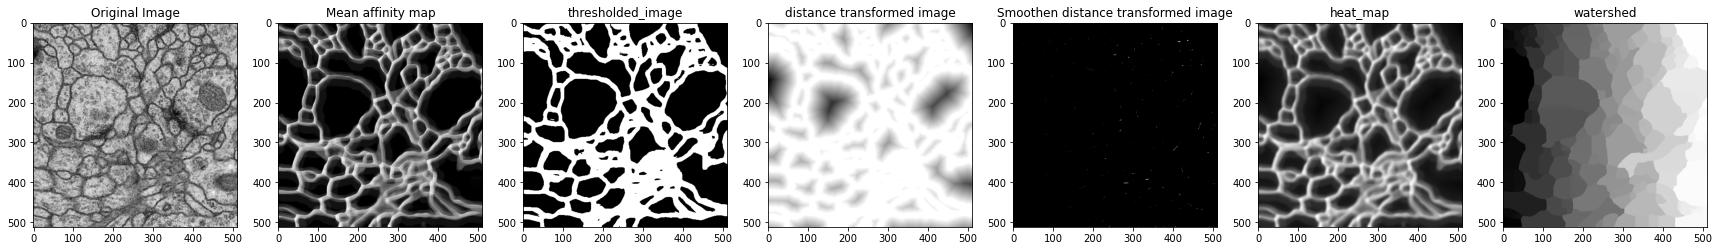

In [ ]:
# next, run  distance transform watershed.the data is very anisotropic, so apply the watershed in 2d and stack the watershed results along z, with the appropriate id offset

# threshold the input and compute distance transform
i=int(input('enter a number between o to 29 of which image is to be segmented:'))

watershd = np.zeros_like(boundary_input[i], dtype='uint64')
threshold=0.25
thresholded = (boundary_input[i] > threshold).astype('uint32')

dt = vigra.filters.distanceTransform(thresholded, pixel_pitch=None)

# compute seeds from maxima of the (smoothed) distance transform
sigma_seeds=2.
dt_sigma = ff.gaussianSmoothing(dt, sigma_seeds)

#Find local maxima in an image and mark them with the given ‘marker’. Parameter ‘neighborhood’
compute_maxima = vigra.analysis.localMaxima if dt.ndim == 2 else vigra.analysis.localMaxima3D # maxima function
seeds = compute_maxima(dt, marker=np.nan, allowAtBorder=True, allowPlateaus=True) #computing local maxima
seeds = np.isnan(seeds)
seeds = vigra.analysis.labelMultiArrayWithBackground(seeds.view('uint8'))
print(seeds.shape)

# normalize and invert distance transform
dt = 1. - (dt - dt.min()) / dt.max()

# compute weights from input and distance transform
alpha=.9
sigma_weights=2
hmap = alpha * ff.gaussianSmoothing(boundary_input[i], sigma_weights) + (1. - alpha) * dt


#compute watershed
min_size=100
#ws, max_id = watershed(hmap, seeds, size_filter=min_size)
watershd, max_id = vigra.analysis.watershedsNew(hmap, seeds=seeds)

ws, max_id = apply_size_filter(watershd, boundary_input[i], min_size)

# if mask is not None:
#     ws[inv_mask] = 0  

display = [raw[0], boundary_input[i],thresholded,dt,seeds,hmap,watershd ]
label = ['Original Image', 'Mean affinity map','thresholded_image','distance transformed image','Smoothen distance transformed image','heat_map','watershed']
fig = plt.figure(figsize=(30,10))

for i in range(len(display)):
  p=np.int(len(display)/2)
  fig.add_subplot(2,7, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()

In [ ]:
watershed_final = np.zeros_like(boundary_input, dtype='uint32')
offset = np.zeros([512,512],dtype='uint32')

for z in range(watershed_final.shape[0]):
    # the threshold parameter determines at which value the input map is thresholded before applying
    # the distance transform.
    # the parameter sigma_seeds determines how strong the seed map is smoothed before seeds are
    # computed via local minima. This controls the degree of over-segmentation
    wsz, max_id = distance_transform_watershed(boundary_input[z], threshold=.25, sigma_seeds=2.)
    wsz += offset
    offset += max_id
    watershed_final[z] = wsz

In [ ]:
# writeHDF5(mc_seg,  os.path.join('mws_data_isbi/result_folder_mws', 'watershed_test.h5'),
#               'data', compression='gzip')
# segmentations.append(watershed_final)
# labels.append('watershed')

# Multicut Method

In [ ]:
def make_pmap(affinities):
    return np.maximum(affinities[1], affinities[2])


def make_pmap3d(affinities):
    return np.mean(affinities[:3])

In [ ]:
pmap = make_pmap(affinities)

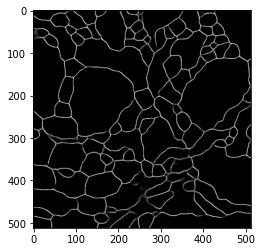

In [ ]:
plt.imshow(pmap[0],cmap='gray')

In [ ]:
@staticmethod
def get_2d_from_3d_offsets(offsets):
    # only keep in-plane channels
    keep_channels = [ii for ii, off in enumerate(offsets) if off[0] == 0]
    offsets = [off[1:] for ii, off in enumerate(offsets) if ii in keep_channels]
    return keep_channels, offsets
def probs_to_costs(probs, beta=.5):
    p_min = 0.001
    p_max = 1. - p_min
    costs = (p_max - p_min) * probs + p_min
    # probabilities to energies, second term is boundary bias
    costs = np.log((1. - costs) / costs) + np.log((1. - beta) / beta)
    return costs
def multicut(n_nodes, uvs, costs, time_limit=None):
    graph = nifty.graph.UndirectedGraph(n_nodes)
    graph.insertEdges(uvs)
    obj = nmc.multicutObjective(graph, costs)
    solver = obj.kernighanLinFactory(warmStartGreedy=True).create(obj)
    if time_limit is not None:
        visitor = obj.verboseVisitor(visitNth=100000000, timeLimitSolver=time_limit)
        node_labels = solver.optimize(visitor=visitor)
    else:
        node_labels = solver.optimize()
    return node_labels

In [ ]:
class WatershedBase(object):
    def __init__(self, grower):
        # check that this is callable
        self.grower = grower

    def __call__(self, affinities):
        return self.grower(affinities)

    @staticmethod
    def get_2d_from_3d_offsets(offsets):
        # only keep in-plane channels
        keep_channels = [ii for ii, off in enumerate(offsets) if off[0] == 0]
        offsets = [off[1:] for ii, off in enumerate(offsets) if ii in keep_channels]
        return keep_channels, offsets

In [ ]:
def superpixel_stacked_from_affinities(affinities, sp2d_fu, n_threads):
    segmentation = np.zeros(affinities.shape[1:], dtype='uint32')

    def run_sp_2d(z):
        seg, off = sp2d_fu(affinities[:, z])
        segmentation[z] = seg
        return off + 1

    with futures.ThreadPoolExecutor(max_workers=n_threads) as tp:
        tasks = [tp.submit(run_sp_2d, z) for z in range(len(segmentation))]
        offsets = [t.result() for t in tasks]

    offsets = np.roll(offsets, 1)
    offsets[0] = 0
    offsets = np.cumsum(offsets).astype('uint32')
    segmentation += offsets[:, None, None]
    return segmentation, segmentation.max()

In [ ]:
def size_filter(hmap, seg, threshold):
    import vigra
    segments, counts = np.unique(seg, return_counts=True)
    mask = np.ma.masked_array(seg, np.in1d(seg, segments[counts < threshold])).mask
    filtered = seg.copy()
    filtered[mask] = 0
    filtered, _ = vigra.analysis.watershedsNew(hmap, seeds=filtered.astype("uint32"))
    filtered, max_label, _ = vigra.analysis.relabelConsecutive(filtered, start_label=1)
    return filtered, max_label

In [ ]:
class McSuperpixel(WatershedBase):
    def __init__(self, beta=.5, min_segment_size=0, stacked_2d=False, n_threads=1):
        self.beta = beta
        self.min_segment_size = min_segment_size
        self.stacked_2d = stacked_2d
        self.n_threads = n_threads

    def mc_superpixel(self, affinities):
        shape = affinities.shape[1:]     #Image shape
        grid_graph = nifty.graph.undirectedGridGraph(shape)  # Graph of image size with each pixel as a node
        costs = grid_graph.affinitiesToEdgeMap(affinities)   
        assert len(costs) == grid_graph.numberOfEdges
        costs = probs_to_costs(costs, beta=self.beta)
        segmentation = multicut(
            grid_graph.numberOfNodes,
            grid_graph.uvIds(),
            costs
        ).reshape(shape)
        if self.min_segment_size > 0:
            affinities = np.sum(affinities, axis=0)
            segmentation, max_label = size_filter(affinities, segmentation, self.min_segment_size)
        else:
            max_label = segmentation.max()
        return segmentation, max_label

    def __call__(self, affinities):
        if self.stacked_2d:
            assert affinities.shape[0] >= 3
            affinities_ = np.require(affinities[1:3], requirements='C')
            segmentation, _ = superpixel_stacked_from_affinities(affinities_, self.mc_superpixel, self.n_threads)

        else:
            if affinities.shape[0] > 3:
                affinities_ = np.require(affinities[:3], requirements='C')
            else:
                affinities_ = affinities
            segmentation, _ = self.mc_superpixel(affinities_)
        return segmentation

In [ ]:
affinities.shape[1:]

(30, 512, 512)

In [ ]:
def compute_mc_superpixels(affinities, n_threads):
    segmenter = McSuperpixel(stacked_2d=True, n_threads=n_threads)
    return segmenter(affinities)

In [ ]:
# TODO
@timer
def mc_baseline(affinities):
    
    return compute_mc_superpixels(affinities, n_threads=8)

In [ ]:
mc=True
if mc:
    print("Computing multicut segmentation ...")
    mc_seg, t_mc = mc_baseline(affinities)
    print("... finished in  %f s" % t_mc)

#     writeHDF5(mc_seg,  os.path.join('mws_data_isbi/result_folder_mws', 'mc_test.h5'),
#               'data', compression='gzip')
#     segmentations.append(mc_seg)
#     labels.append('local multicut')

Computing multicut segmentation ...
... finished in  233.008817 s


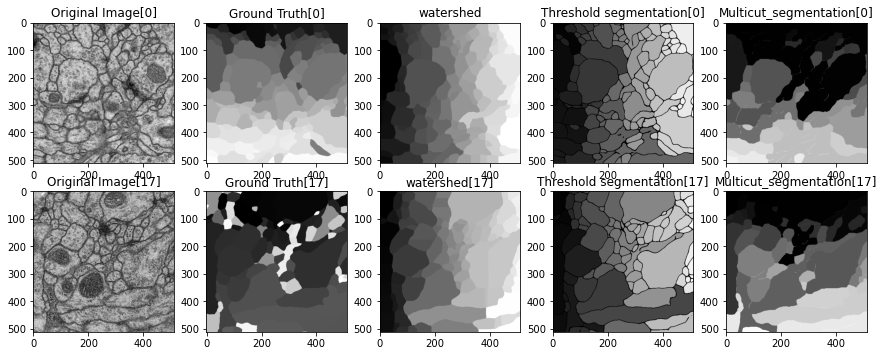

In [ ]:
display = [raw[0],groundtruth[0],watershed_final[0],thresh_seg[0],mc_seg[0],raw[17],groundtruth[17],watershed_final[17],thresh_seg[17],mc_seg[17]]
label = ['Original Image[0]', 'Ground Truth[0]','watershed','Threshold segmentation[0]','Multicut_segmentation[0]','Original Image[17]', 'Ground Truth[17]','watershed[17]','Threshold segmentation[17]','Multicut_segmentation[17]']
fig = plt.figure(figsize=(15,15))

for i in range(len(display)):
  p=np.int(len(display)/2)
  fig.add_subplot(p,p, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()

In [ ]:
def make_2d_edges(segmentation):
    gx = convolve(segmentation + 1, np.array([-1., 1.]).reshape(1, 2))
    gy = convolve(segmentation + 1, np.array([-1., 1.]).reshape(2, 1))
    return ((gx ** 2 + gy ** 2) > 0)


def make_edges(segmentation):
    edges = np.zeros_like(segmentation, dtype='uint64')
    for z in range(segmentation.shape[0]):
        edges[z] = make_2d_edges(segmentation[z])
    return edges


#def view_res():
raw_path = 'mws_data_isbi/isbi_train_volume.h5'
with h5py.File(raw_path) as f:
    raw = f['raw'][:]

seg_path = 'mws_data_isbi/result_folder_mws/mc_train.h5'
with h5py.File(seg_path) as f:
    seg = f['data'][:]

edges_mc = make_edges(seg)

edges_watershed =make_edges(watershed_final)

edges_Threshold =make_edges(thresh_seg)

    #view([raw, seg, edges], ['raw', 'local multicut', 'edges'])

C:\Users\NICKY\Anaconda3\envs\Biomed\lib\site-packages\ipykernel_launcher.py:16: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  app.launch_new_instance()
C:\Users\NICKY\Anaconda3\envs\Biomed\lib\site-packages\ipykernel_launcher.py:20: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


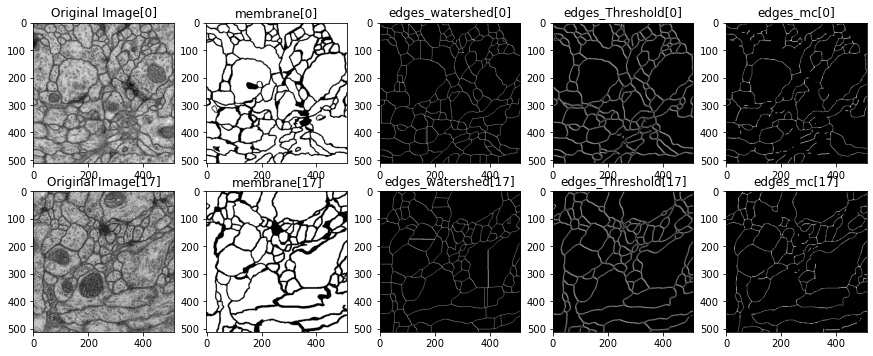

In [ ]:

display = [raw[0],membranes[0],edges_watershed[0],edges_Threshold[0],edges_mc[0],raw[17],membranes[17],edges_watershed[17],edges_Threshold[17],edges_mc[17]]
label = ['Original Image[0]', 'membrane[0]','edges_watershed[0]','edges_Threshold[0]','edges_mc[0]','Original Image[17]', 'membrane[17]','edges_watershed[17]','edges_Threshold[17]','edges_mc[17]']
fig = plt.figure(figsize=(15,15))

for i in range(len(display)):
  p=np.int(len(display)/2)
  fig.add_subplot(p,p, i+1)
  plt.imshow(display[i], cmap = 'gray')
  plt.title(label[i])

plt.show()

In [ ]:
import numpy as np
import scipy.sparse as sparse

In [ ]:
def adapted_rand(seg, gt, all_stats=False):
    """Compute Adapted Rand error as defined by the SNEMI3D contest [1]
    Formula is given as 1 - the maximal F-score of the Rand index 
    (excluding the zero component of the original labels). Adapted 
    from the SNEMI3D MATLAB script, hence the strange style.
    Parameters
    ----------
    seg : np.ndarray
        the segmentation to score, where each value is the label at that point
    gt : np.ndarray, same shape as seg
        the groundtruth to score against, where each value is a label
    all_stats : boolean, optional
        whether to also return precision and recall as a 3-tuple with rand_error
    Returns
    -------
    are : float
        The adapted Rand error; equal to $1 - \frac{2pr}{p + r}$,
        where $p$ and $r$ are the precision and recall described below.
    prec : float, optional
        The adapted Rand precision. (Only returned when `all_stats` is ``True``.)
    rec : float, optional
        The adapted Rand recall.  (Only returned when `all_stats` is ``True``.)
    References
    ----------
    [1]: http://brainiac2.mit.edu/SNEMI3D/evaluation
    """
    # segA is truth, segB is query
    segA = np.ravel(gt)
    segB = np.ravel(seg)
    n = segA.size

    n_labels_A = int(np.amax(segA) + 1)
    n_labels_B = int(np.amax(segB) + 1)

    ones_data = np.ones(n)

    p_ij = sparse.csr_matrix((ones_data, (segA[:], segB[:])), shape=(n_labels_A, n_labels_B))

    a = p_ij[1:n_labels_A,:]
    b = p_ij[1:n_labels_A,1:n_labels_B]
    c = p_ij[1:n_labels_A,0].todense()
    d = b.multiply(b)

    a_i = np.array(a.sum(1))
    b_i = np.array(b.sum(0))

    sumA = np.sum(a_i * a_i)
    sumB = np.sum(b_i * b_i) + (np.sum(c) / n)
    sumAB = np.sum(d) + (np.sum(c) / n)

    precision = sumAB / sumB
    recall = sumAB / sumA

    fScore = 2.0 * precision * recall / (precision + recall)
    are = 1.0 - fScore

    if all_stats:
        return (are, precision, recall)
    else:
        return are

# Metric Analysis or multicut

# For Watershed-DT Segmentation

In [ ]:
mc_rand_gt=adapted_rand(watershed_final[0], groundtruth[0], all_stats=True)
mc_rand_gt

(0.3073503107297, 0.8423443194023017, 0.5881316770541092)

In [ ]:
mc_rand_gt=adapted_rand(watershed_final[18], groundtruth[18], all_stats=True)
mc_rand_gt

(0.35783399757701473, 0.8772499575208519, 0.5064487308677414)

In [ ]:
mc_rand_gt=adapted_rand(watershed_final[27], groundtruth[27], all_stats=True)
mc_rand_gt

(0.2478016842317481, 0.8811552169159756, 0.6561682195884794)

# For threshold Segmentation

In [ ]:
thresh_rand_gt=adapted_rand(thresh_seg[0], groundtruth[0], all_stats=True)
thresh_rand_gt

(0.17535196704949962, 0.8550028203069563, 0.7963746940561803)

In [ ]:
thresh_rand_gt=adapted_rand(thresh_seg[18], groundtruth[18], all_stats=True)
thresh_rand_gt

(0.06815487727151126, 0.9923623147256618, 0.8782847201907705)

In [ ]:
thresh_rand_gt=adapted_rand(thresh_seg[27], groundtruth[27], all_stats=True)
thresh_rand_gt

(0.09580683448669691, 0.9432701281763998, 0.8682251019861893)

# For MC Segmentation

In [ ]:
mc_rand=adapted_rand(mc_seg[0], groundtruth[0], all_stats=True)

mc_rand

(0.5091741898237192, 0.33931761538297944, 0.8867810941246677)

In [ ]:
mc_rand=adapted_rand(mc_seg[18], groundtruth[18], all_stats=True)
mc_rand

(0.4096820003836984, 0.43301135112227507, 0.9271310651175791)

In [ ]:
mc_rand=adapted_rand(mc_seg[27], groundtruth[27], all_stats=True)
mc_rand

(0.4806141706104514, 0.35950685349085043, 0.9353541575643772)